<a href="https://colab.research.google.com/github/riddhikaa/SKYhack3.0_meow/blob/main/Final_skyhack3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

# === 1. Loading datasets ===
flight_df = pd.read_csv("/content/drive/MyDrive/UNITED/Flight Level Data.csv")
bag_df = pd.read_csv("/content/drive/MyDrive/UNITED/Bag+Level+Data.csv")
pnr_flight_df = pd.read_csv("/content/drive/MyDrive/UNITED/PNR+Flight+Level+Data.csv")
pnr_remark_df = pd.read_csv("/content/drive/MyDrive/UNITED/PNR Remark Level Data.csv")
airports_df = pd.read_csv("/content/drive/MyDrive/UNITED/Airports Data.csv")


# Consolidating Datasets in one master dataset
flight_key = ['company_id', 'flight_number', 'scheduled_departure_date_local']

master_df = flight_df.copy()
print(f"DataFrame created with {len(master_df)} flights.")

bag_df['is_transfer'] = (bag_df['bag_type'] == 'Transfer').astype(int)
bag_summary = bag_df.groupby(flight_key).agg(
    total_bags=('bag_tag_unique_number', 'count'),
    transfer_bags=('is_transfer', 'sum')
).reset_index()

master_df = pd.merge(master_df, bag_summary, on=flight_key, how='left')

unique_pnrs_per_flight = pnr_flight_df.drop_duplicates(subset=flight_key + ['record_locator'])

pax_summary = unique_pnrs_per_flight.groupby(flight_key).agg(
    total_pax=('total_pax', 'sum')
).reset_index()

pax_attributes_summary = pnr_flight_df.groupby(flight_key).agg(
    children=('is_child', lambda x: (x == 'Y').sum()),
    stroller_users=('is_stroller_user', lambda x: (x == 'Y').sum()),
    lap_children=('lap_child_count', 'sum')
).reset_index()

pnr_summary = pd.merge(pax_summary, pax_attributes_summary, on=flight_key, how='left')

master_df = pd.merge(master_df, pnr_summary, on=flight_key, how='left')

pnr_key_map = pnr_flight_df[flight_key + ['record_locator']].drop_duplicates()

enriched_remarks = pd.merge(pnr_remark_df, pnr_key_map, on=['record_locator', 'flight_number'], how='inner')

ssr_summary = enriched_remarks.groupby(flight_key).agg(
    special_service_requests=('special_service_request', 'count')
).reset_index()

master_df = pd.merge(master_df, ssr_summary, on=flight_key, how='left')


master_df = pd.merge(master_df, airports_df, left_on='scheduled_arrival_station_code', right_on='airport_iata_code', how='left')

count_cols = [
    'total_bags', 'transfer_bags', 'total_pax', 'children',
    'stroller_users', 'lap_children', 'special_service_requests'
]
for col in count_cols:
    if col in master_df.columns:
        master_df[col] = master_df[col].fillna(0)

print(f"The final unified dataset has {master_df.shape[0]} rows and {master_df.shape[1]} columns.")
print("Preview of the first 5 rows:")
print(master_df.head())

DataFrame created with 8099 flights.
The final unified dataset has 8099 rows and 24 columns.
Preview of the first 5 rows:
  company_id  flight_number scheduled_departure_date_local  \
0         OO           4792                     2025-08-04   
1         UA            920                     2025-08-03   
2         UA           1776                     2025-08-10   
3         OO           5790                     2025-08-06   
4         UA           1398                     2025-08-05   

  scheduled_departure_station_code scheduled_arrival_station_code  \
0                              ORD                            ROA   
1                              ORD                            LHR   
2                              ORD                            PHL   
3                              ORD                            CRW   
4                              ORD                            ATL   

  scheduled_departure_datetime_local scheduled_arrival_datetime_local  \
0               2

In [3]:
# Evaluating Contextual Feature
#  1) Airport Congestion Score
# all flights are from same airport - ord
try:

    master_df['scheduled_departure_datetime_local'] = pd.to_datetime(master_df['scheduled_departure_datetime_local'])

    master_df = master_df.sort_values(by='scheduled_departure_datetime_local').reset_index(drop=True)
    time_indexed_df = master_df.set_index('scheduled_departure_datetime_local')
    congestion_counts = time_indexed_df['flight_number'].rolling('60min', center=True).count() - 1
    master_df['congestion_score'] = congestion_counts.values

    print(master_df[['flight_number', 'scheduled_departure_datetime_local', 'congestion_score']].head())


except FileNotFoundError:
    print("Please ensure 'unified_flight_data.csv' is in the directory.")
except Exception as e:
    print(f"An error occurred: {e}")

   flight_number scheduled_departure_datetime_local  congestion_score
0           2666          2025-08-01 05:00:00+00:00               0.0
1           1077          2025-08-01 06:00:00+00:00               6.0
2            468          2025-08-01 06:00:00+00:00               6.0
3           1658          2025-08-01 06:00:00+00:00               6.0
4           2104          2025-08-01 06:00:00+00:00               6.0


In [4]:
# 2) Weather Condition
# Flight data (date, time, and airport code)


import requests
import time

    # This function will fetche weather data for a specific hour from the Open-Meteo API.( https://open-meteo.com/ )
    # Since all flights are from ORD, we'll use the coordinates. ORD is approx. lat: 41.97 and long: -87.90 --> this will be used in api calls
    # we'll focus on 'temperature', 'precipitation', and 'windspeed'
def get_weather_for_flight(row):
    lat = 41.97
    lon = -87.90

    date = row['scheduled_departure_date_local']
    hour = pd.to_datetime(row['scheduled_departure_datetime_local']).hour

    url = f"https://archive-api.open-meteo.com/v1/archive?latitude={lat}&longitude={lon}&start_date={date}&end_date={date}&hourly=temperature_2m,precipitation,windspeed_10m"

    try:
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            hourly_data = data.get('hourly', {})

            temp = hourly_data.get('temperature_2m', [None]*24)[hour]
            precipitation = hourly_data.get('precipitation', [None]*24)[hour]
            windspeed = hourly_data.get('windspeed_10m', [None]*24)[hour]

            return temp, precipitation, windspeed
        else:
            return None, None, None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None, None


try:
    print("Fetching weather data for each flight. This may take a while...")
    unique_dates = master_df['scheduled_departure_date_local'].unique()
    weather_cache = {}

    for date in unique_dates:
        url = f"https://archive-api.open-meteo.com/v1/archive?latitude=41.97&longitude=-87.90&start_date={date}&end_date={date}&hourly=temperature_2m,precipitation,windspeed_10m"
        try:
            response = requests.get(url)
            if response.status_code == 200:
                weather_cache[date] = response.json().get('hourly', {})
            else:
                weather_cache[date] = {}
        except Exception:
            weather_cache[date] = {}
        time.sleep(0.5) # being kind to api lol

    def get_weather_from_cache(row):
        date = row['scheduled_departure_date_local']
        hour = pd.to_datetime(row['scheduled_departure_datetime_local']).hour
        daily_weather = weather_cache.get(date, {})

        temp = daily_weather.get('temperature_2m', [None]*24)[hour]
        precip = daily_weather.get('precipitation', [None]*24)[hour]
        wind = daily_weather.get('windspeed_10m', [None]*24)[hour]
        return pd.Series([temp, precip, wind])


    master_df[['temperature', 'precipitation', 'windspeed']] = master_df.apply(get_weather_from_cache, axis=1)

    print(master_df[['flight_number', 'scheduled_departure_datetime_local', 'temperature', 'precipitation', 'windspeed']].head())

except FileNotFoundError:
    print("Please ensure 'unified_flight_data.csv' is in the directory.")
except Exception as e:
    print(f"An error occurred during processing: {e}")

Fetching weather data for each flight. This may take a while...
   flight_number scheduled_departure_datetime_local  temperature  \
0           2666          2025-08-01 05:00:00+00:00         17.7   
1           1077          2025-08-01 06:00:00+00:00         17.6   
2            468          2025-08-01 06:00:00+00:00         17.6   
3           1658          2025-08-01 06:00:00+00:00         17.6   
4           2104          2025-08-01 06:00:00+00:00         17.6   

   precipitation  windspeed  
0            0.0       12.8  
1            0.0       11.6  
2            0.0       11.6  
3            0.0       11.6  
4            0.0       11.6  


In [5]:
# Saving the consolidated data file
master_df.to_csv('unified_flight_data.csv', index=False)


In [6]:
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler

In [7]:
# --- 2. FEATURE ENGINEERING ---
for col in ['scheduled_departure_datetime_local', 'actual_departure_datetime_local']:
    master_df[col] = pd.to_datetime(master_df[col], errors='coerce')

# A) Creating a proxy target variable: 'is_delayed'
master_df['departure_delay_minutes'] = (master_df['actual_departure_datetime_local'] - master_df['scheduled_departure_datetime_local']).dt.total_seconds() / 60
master_df['is_delayed'] = (master_df['departure_delay_minutes'] > 15).astype(int)

# B) Creating Difficulty Driver Features
master_df['ground_time_pressure'] = master_df['minimum_turn_minutes'] - master_df['scheduled_ground_time_minutes']
master_df['passenger_load_factor'] = master_df['total_pax'] / master_df['total_seats']
master_df['transfer_bag_ratio'] = master_df['transfer_bags'] / master_df['total_bags']
master_df['special_service_ratio'] = master_df['special_service_requests'] / master_df['total_pax']
master_df['is_international'] = (master_df['iso_country_code'] != 'US').astype(int)
master_df['departure_hour'] = pd.to_datetime(master_df['scheduled_departure_datetime_local']).dt.hour
master_df['day_of_week'] = pd.to_datetime(master_df['scheduled_departure_datetime_local']).dt.dayofweek


master_df.replace([np.inf, -np.inf], np.nan, inplace=True)
master_df[['passenger_load_factor', 'transfer_bag_ratio', 'special_service_ratio']] = master_df[['passenger_load_factor', 'transfer_bag_ratio', 'special_service_ratio']].fillna(0)

master_df.dropna(subset=['departure_delay_minutes'], inplace=True)


In [8]:
# --- 3. TRAIN GRADIENT BOOSTING MODEL TO FIND FEATURE IMPORTANCE ---

features = [
    'ground_time_pressure', 'passenger_load_factor', 'transfer_bag_ratio',
    'special_service_ratio', 'is_international', 'departure_hour',
    'day_of_week', 'total_pax', 'total_bags', 'children',
    'stroller_users', 'lap_children',
     'temperature', 'precipitation', 'windspeed', 'congestion_score' # <--- contextual features
]
X = master_df[features]
y = master_df['is_delayed']

lgbm = lgb.LGBMClassifier(objective='binary', random_state=42)
lgbm.fit(X, y)

feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': lgbm.feature_importances_
}).sort_values('importance', ascending=False)

print("\nModel training complete.")

# --- 4. EVALUATION OF THE FLIGHT DIFFICULTY SCORE ---

feature_importance_df['weight'] = feature_importance_df['importance'] / feature_importance_df['importance'].sum()

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(master_df[features])
scaled_features_df = pd.DataFrame(scaled_features, columns=features)

weights = feature_importance_df.set_index('feature')['weight']
master_df['difficulty_score'] = scaled_features_df[weights.index].mul(weights).sum(axis=1)
master_df['difficulty_score'] = MinMaxScaler(feature_range=(0, 100)).fit_transform(master_df[['difficulty_score']])



# --- 5. RANKING AND CLASSIFICATION OF FLIGHTS ---

master_df['daily_difficulty_rank'] = master_df.groupby('scheduled_departure_date_local')['difficulty_score'].rank(method='dense', ascending=False)
master_df['difficulty_category'] = master_df.groupby('scheduled_departure_date_local')['difficulty_score'].transform(
    lambda x: pd.qcut(x, q=[0, 0.25, 0.75, 1], labels=['Easy', 'Medium', 'Difficult'], duplicates='drop')
)

print("\n--- RESULTS ---")
print("\nTop 10 Drivers of Flight Difficulty (from LightGBM Model):")
print(feature_importance_df.head(10).to_string(index=False))

print("\nTop 10 Most Difficult Flights:")
top_flights = master_df.sort_values('difficulty_score', ascending=False).head(10)
display_cols = [
    'company_id', 'flight_number', 'scheduled_departure_date_local',
    'scheduled_arrival_station_code', 'difficulty_score', 'daily_difficulty_rank', 'difficulty_category'
]
print(top_flights[display_cols].to_string(index=False))

print("\nTop 10 Most Frequently 'Difficult' Destinations:")
difficult_destinations = master_df[master_df['difficulty_category'] == 'Difficult']['scheduled_arrival_station_code'].value_counts().head(10)
print(difficult_destinations)

[LightGBM] [Info] Number of positive: 2163, number of negative: 5936
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1912
[LightGBM] [Info] Number of data points in the train set: 8099, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267070 -> initscore=-1.009539
[LightGBM] [Info] Start training from score -1.009539

Model training complete.

--- RESULTS ---

Top 10 Drivers of Flight Difficulty (from LightGBM Model):
              feature  importance   weight
 ground_time_pressure         430 0.143333
   transfer_bag_ratio         287 0.095667
           total_bags         273 0.091000
passenger_load_factor         257 0.085667
     congestion_score         237 0.079000
          temperature         234 0.078000
special_service_ratio         234 0.07800

Total relative importance: 100.0

===== Top Features Affecting Difficulty Score =====
                  feature  importance    weight  relative_importance (%)  rank
0    ground_time_pressure         430  0.143333                14.333333     1
2      transfer_bag_ratio         287  0.095667                 9.566667     2
8              total_bags         273  0.091000                 9.100000     3
1   passenger_load_factor         257  0.085667                 8.566667     4
15       congestion_score         237  0.079000                 7.900000     5
12            temperature         234  0.078000                 7.800000     6
3   special_service_ratio         234  0.078000                 7.800000     6
14              windspeed         223  0.074333                 7.433333     8
7               total_pax         221  0.073667                 7.366667     9
6             day_of_week         163  0.054333                 5.433333    10


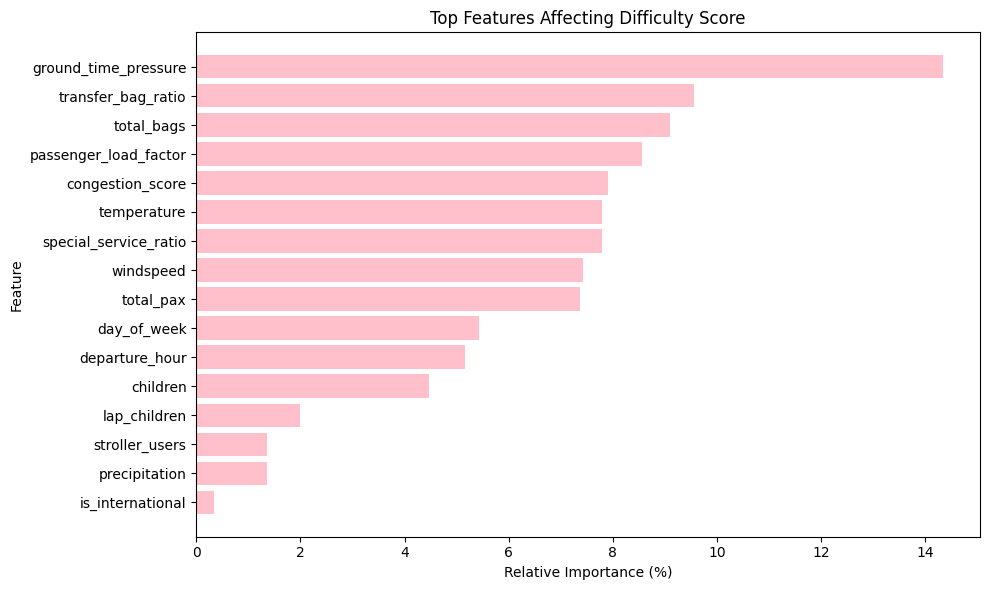

In [9]:
import matplotlib.pyplot as plt

feature_importance_df['relative_importance (%)'] = ( feature_importance_df['importance'] / feature_importance_df['importance'].sum()) * 100

# normalization
feature_importance_df['relative_importance (%)'] = (
    feature_importance_df['relative_importance (%)'] /
    feature_importance_df['relative_importance (%)'].sum()
) * 100


print("Total relative importance:", feature_importance_df['relative_importance (%)'].sum())

feature_importance_df['rank'] = feature_importance_df['relative_importance (%)'].rank(ascending=False).astype(int)



print("\n===== Top Features Affecting Difficulty Score =====")
print(feature_importance_df.head(10))

plt.figure(figsize=(10,6))
plt.barh(feature_importance_df['feature'], feature_importance_df['relative_importance (%)'], color='pink')
plt.gca().invert_yaxis()
plt.title('Top Features Affecting Difficulty Score')
plt.xlabel('Relative Importance (%)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


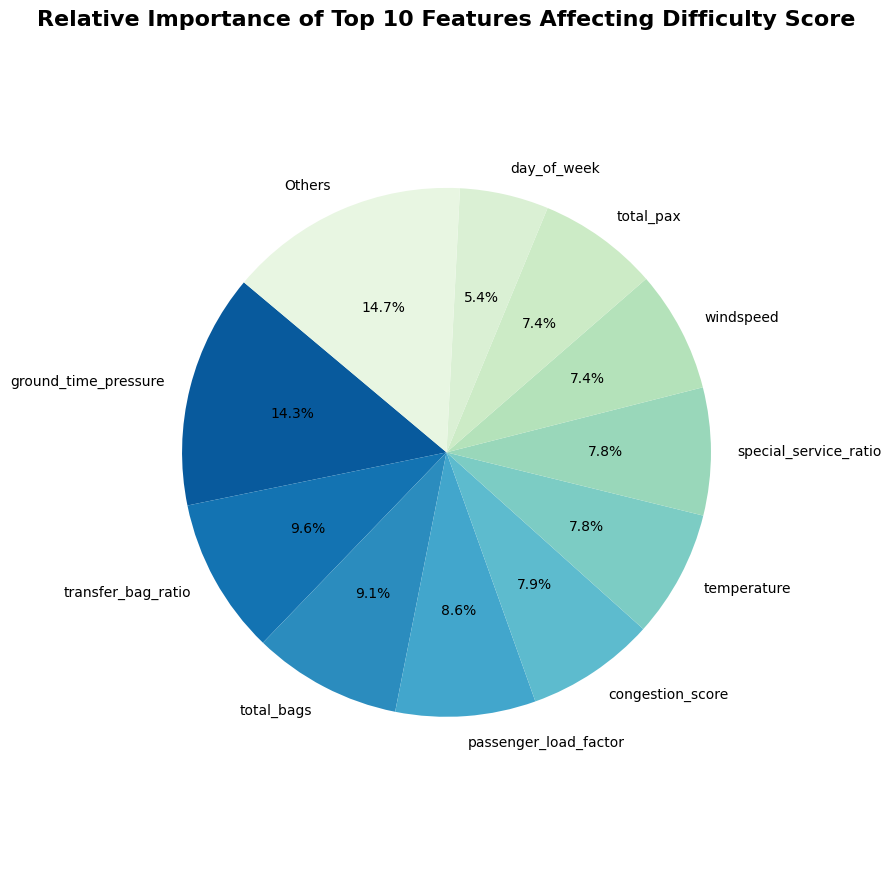

In [10]:
# Pie Chart for top 10 features!
import seaborn as sns
top_n_features = 10
pie_data = feature_importance_df.head(top_n_features).copy()

if len(feature_importance_df) > top_n_features:
    other_importance = feature_importance_df['relative_importance (%)'].iloc[top_n_features:].sum()
    other_row = pd.DataFrame({
        'feature': ['Others'],
        'importance': [0],
        'weight': [0],
        'relative_importance (%)': [other_importance],
        'rank': [top_n_features + 1]
    })
    pie_data = pd.concat([pie_data, other_row], ignore_index=True)



plt.figure(figsize=(9, 9))
plt.pie(
    pie_data['relative_importance (%)'],
    labels=pie_data['feature'],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('GnBu_r', len(pie_data))
)
plt.title('Relative Importance of Top 10 Features Affecting Difficulty Score', fontsize=16, weight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()


Category Counts:
difficulty_category
Easy         2031
Medium       4043
Difficult    2025
Name: count, dtype: int64


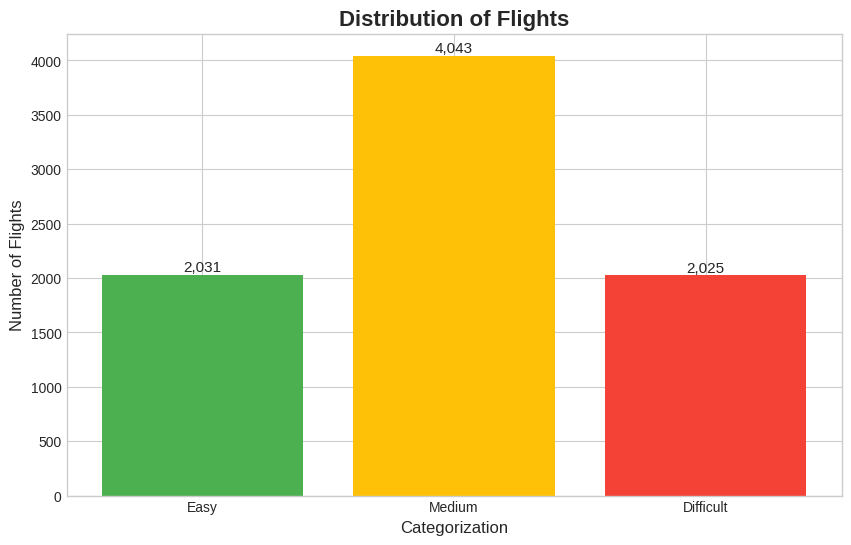

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

category_counts = master_df['difficulty_category'].value_counts()

category_order = ['Easy', 'Medium', 'Difficult']
category_counts = category_counts.reindex(category_order)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#4CAF50', '#FFC107', '#F44336']
bars = ax.bar(category_counts.index, category_counts.values, color=colors)

ax.set_title('Distribution of Flights', fontsize=16, weight='bold')
ax.set_xlabel('Categorization', fontsize=12)
ax.set_ylabel('Number of Flights', fontsize=12)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:,.0f}', ha='center', va='bottom', fontsize=11)

print("\nCategory Counts:")
print(category_counts)

In [12]:
print("\n--- Top 10 Flights per Difficulty Category ---")

display_cols_detailed = [
    'company_id', 'flight_number', 'fleet_type',
    'scheduled_departure_date_local', 'scheduled_arrival_station_code',
    'difficulty_score', 'daily_difficulty_rank'
]

print("\nTop 10 Most Difficult Flights:")
difficult_flights = master_df[master_df['difficulty_category'] == 'Difficult'].sort_values('difficulty_score', ascending=False).head(10)
print(difficult_flights[display_cols_detailed].to_string(index=False))

print("\nTop 10 Medium Difficulty Flights:")
medium_flights = master_df[master_df['difficulty_category'] == 'Medium'].sort_values('difficulty_score', ascending=False).head(10)
print(medium_flights[display_cols_detailed].to_string(index=False))

print("\nTop 10 Easiest Flights:")
easy_flights = master_df[master_df['difficulty_category'] == 'Easy'].sort_values('difficulty_score', ascending=True).head(10)
print(easy_flights[display_cols_detailed].to_string(index=False))


--- Top 10 Flights per Difficulty Category ---

Top 10 Most Difficult Flights:
company_id  flight_number fleet_type scheduled_departure_date_local scheduled_arrival_station_code  difficulty_score  daily_difficulty_rank
        UA            907    B787-10                     2025-08-09                            FRA        100.000000                    1.0
        UA            845    B787-10                     2025-08-08                            GRU         98.493523                    1.0
        UA            845    B787-10                     2025-08-09                            GRU         98.103852                    2.0
        UA            907    B787-10                     2025-08-08                            FRA         96.733474                    2.0
        UA            845    B787-10                     2025-08-10                            GRU         96.069480                    1.0
        UA            972    B787-10                     2025-08-08             

In [13]:
%pip install shap

In [14]:
import shap
explainer = shap.TreeExplainer(lgbm, data=X.sample(8099, random_state=42))

In [15]:
sample_X = X.sample(8099, random_state=42)
shap_values = explainer.shap_values(sample_X)
shap_interaction_values = explainer.shap_interaction_values(sample_X)

 98%|===================| 7972/8099 [00:41<00:00]       


--- SHAP Summary Plot (Bar) ---


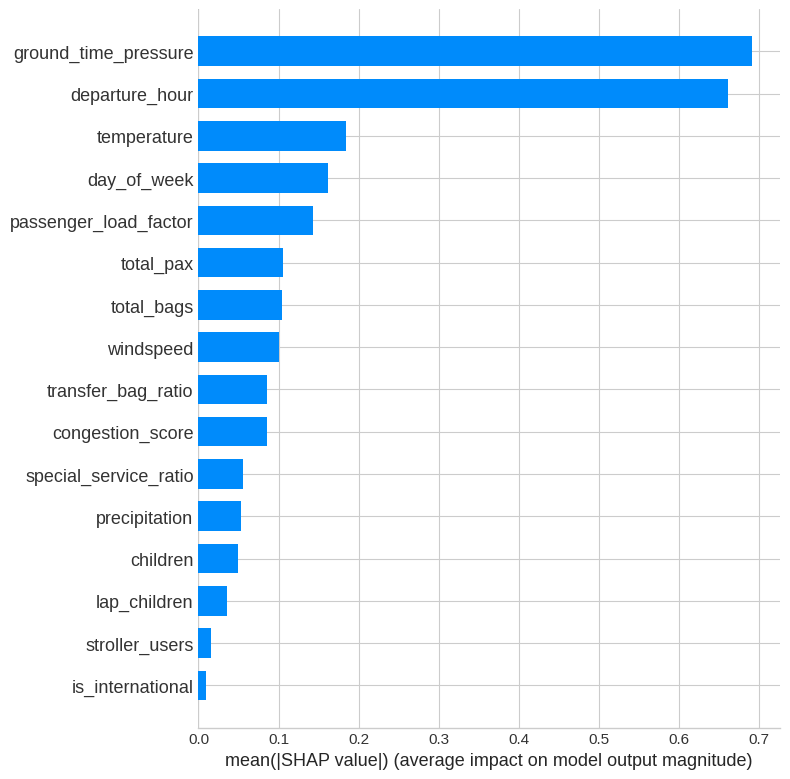


--- SHAP Summary Plot (Dot) ---


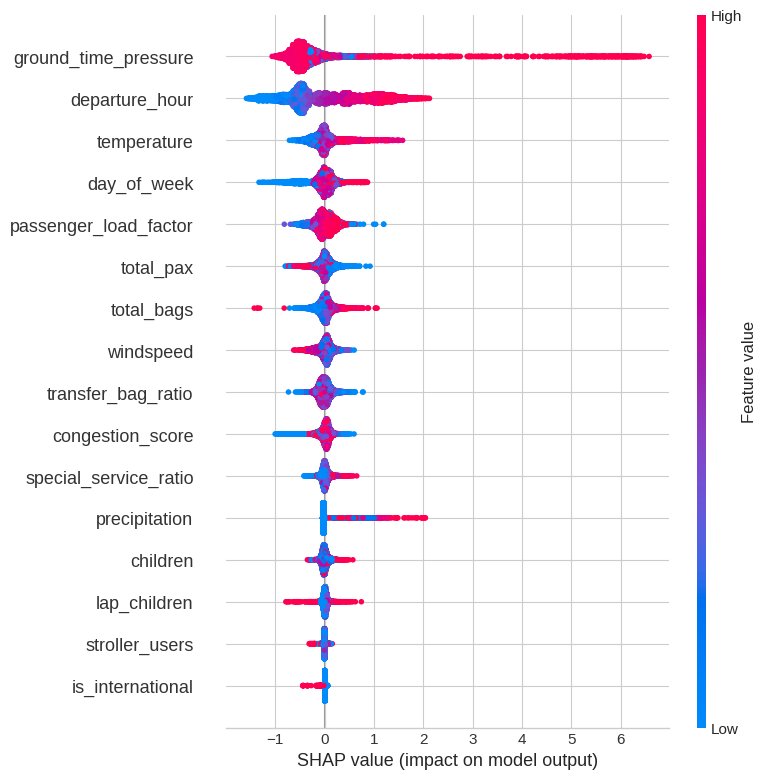

In [16]:
print("\n--- SHAP Summary Plot (Bar) ---")
shap.summary_plot(shap_values, sample_X, plot_type="bar")

print("\n--- SHAP Summary Plot (Dot) ---")
shap.summary_plot(shap_values, sample_X)

In [17]:
import shap
shap.initjs()
instance_index = 0
shap.force_plot(explainer.expected_value, shap_values[instance_index,:], sample_X.iloc[instance_index,:])


--- SHAP Waterfall Plot for a Single Instance ---


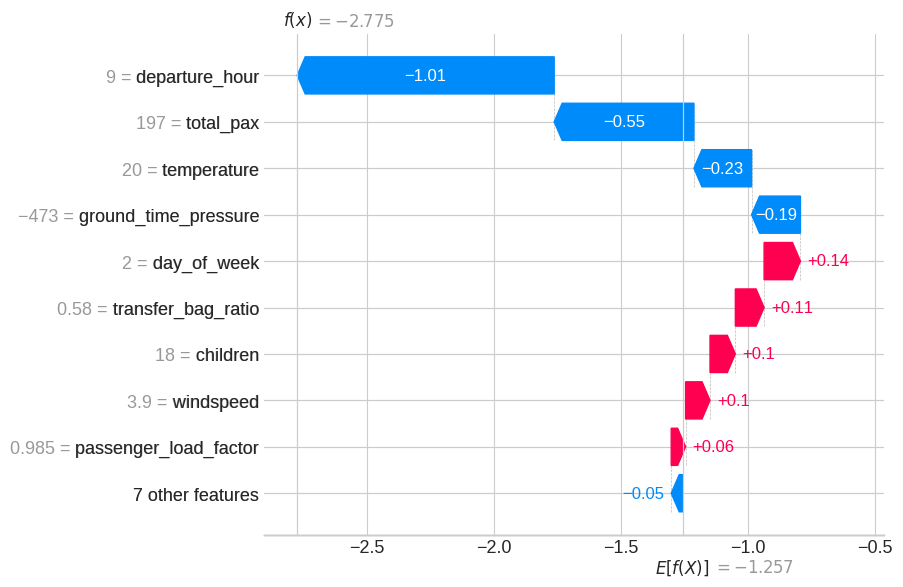

In [19]:
print("\n--- SHAP Waterfall Plot for a Single Instance ---")
instance_index_to_explain = 0
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[instance_index_to_explain],
        base_values=explainer.expected_value,
        data=sample_X.iloc[instance_index_to_explain].values,
        feature_names=sample_X.columns.tolist()
    )
)

In [20]:
%pip install --quiet shap


--- SHAP Interaction Plots for Top Features ---

Interaction between 'ground_time_pressure' and 'transfer_bag_ratio':


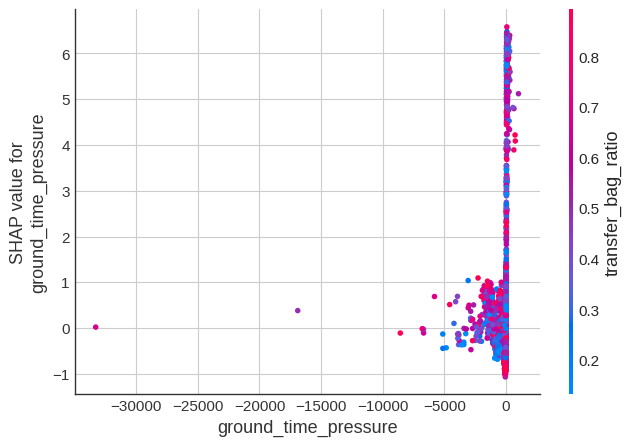


Interaction between 'ground_time_pressure' and 'total_bags':


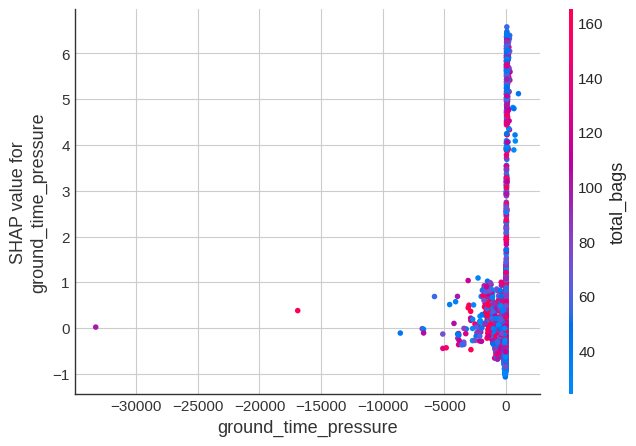


Interaction between 'ground_time_pressure' and 'passenger_load_factor':


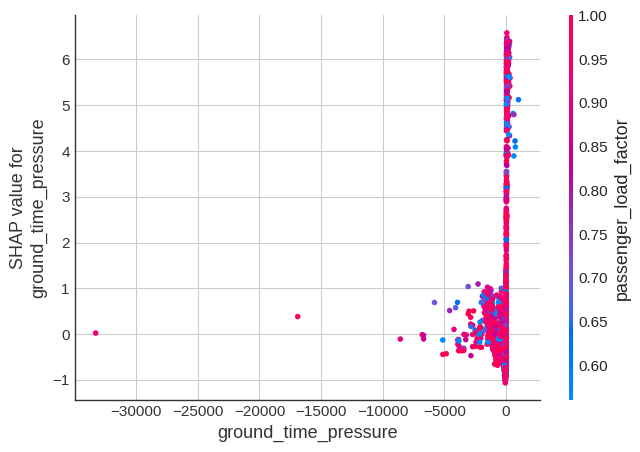


Interaction between 'ground_time_pressure' and 'congestion_score':


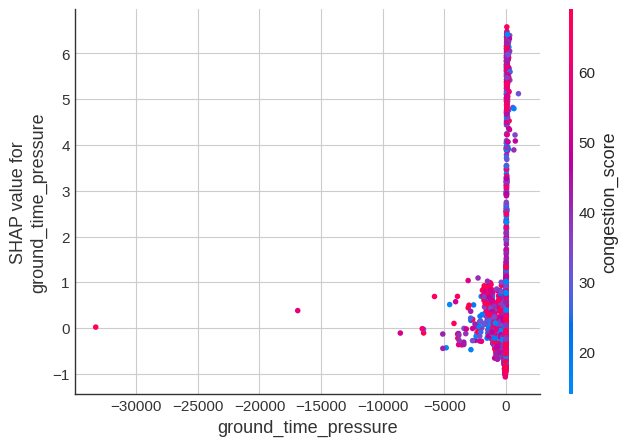


Interaction between 'ground_time_pressure' and 'temperature':


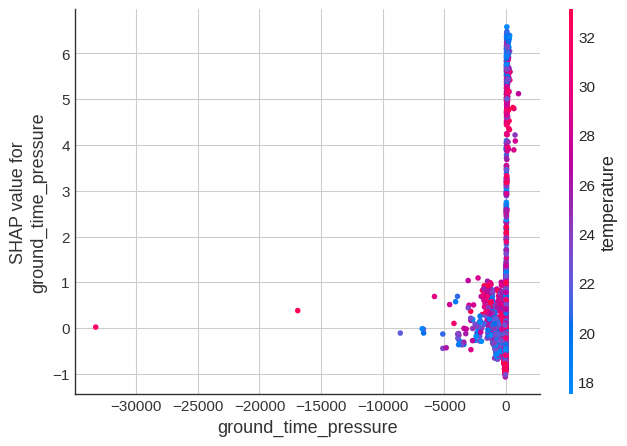


Interaction between 'ground_time_pressure' and 'special_service_ratio':


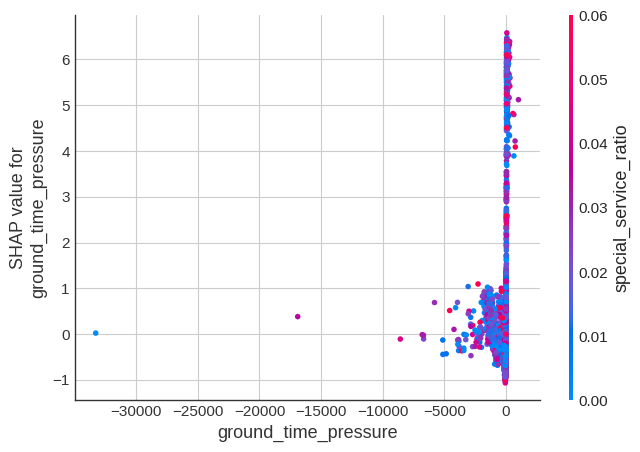


Interaction between 'ground_time_pressure' and 'windspeed':


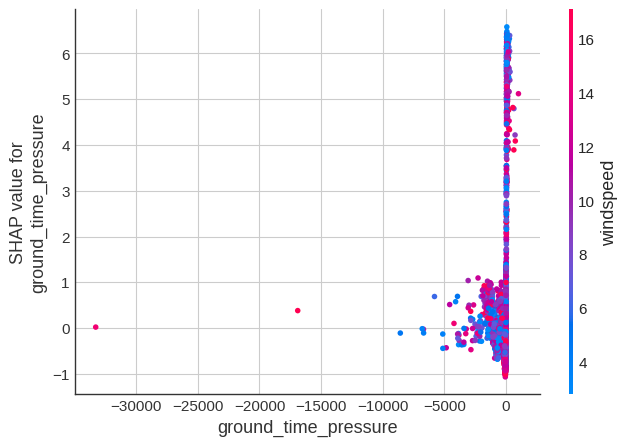


Interaction between 'ground_time_pressure' and 'total_pax':


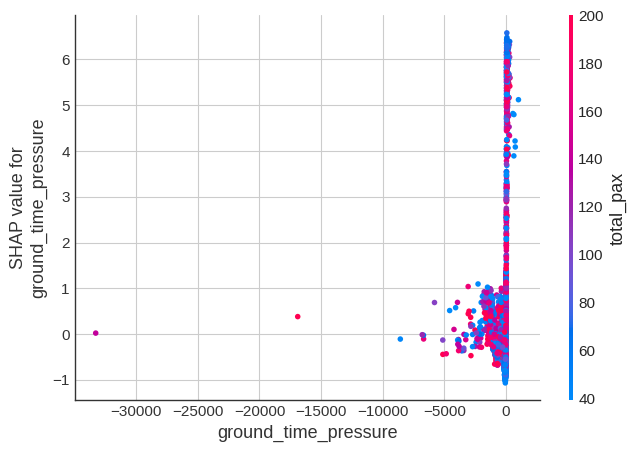


Interaction between 'ground_time_pressure' and 'day_of_week':


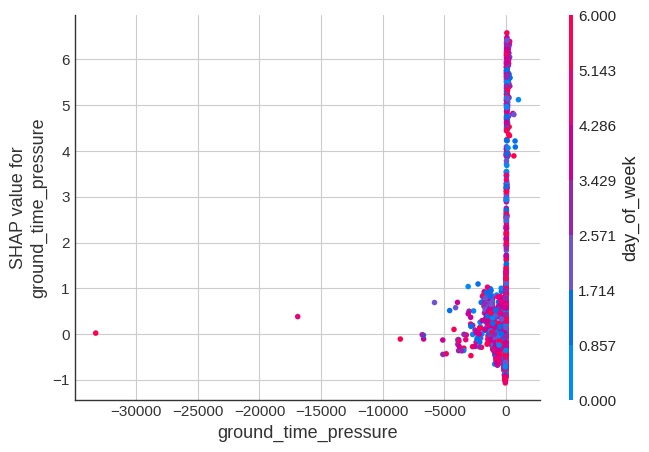


Interaction between 'transfer_bag_ratio' and 'total_bags':


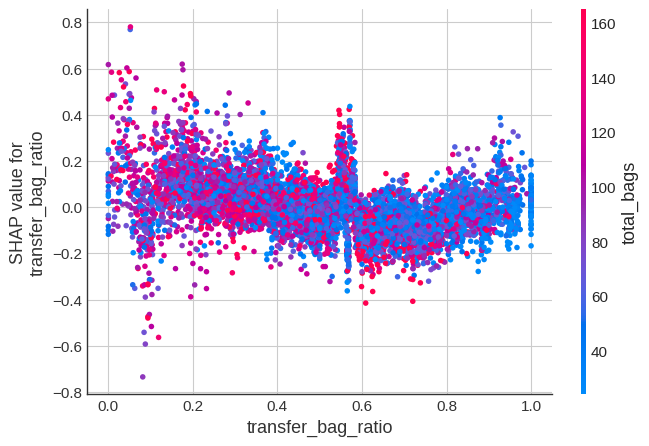


Interaction between 'transfer_bag_ratio' and 'passenger_load_factor':


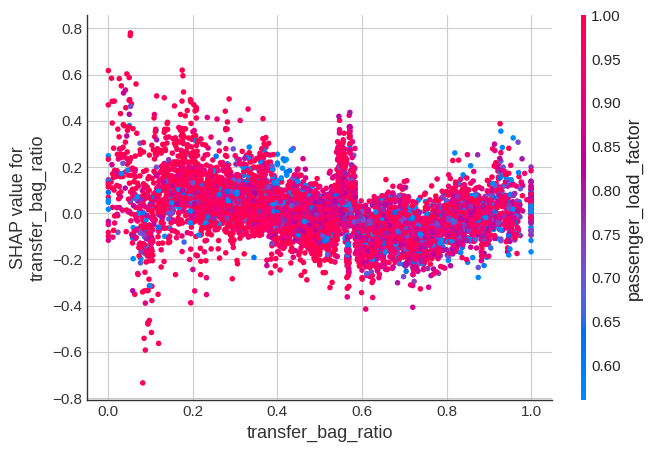


Interaction between 'transfer_bag_ratio' and 'congestion_score':


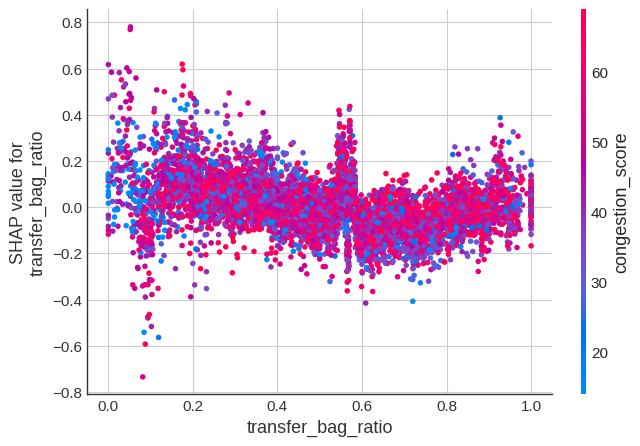


Interaction between 'transfer_bag_ratio' and 'temperature':


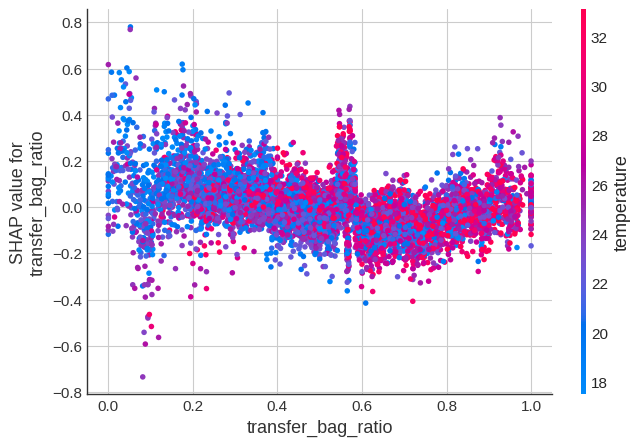


Interaction between 'transfer_bag_ratio' and 'special_service_ratio':


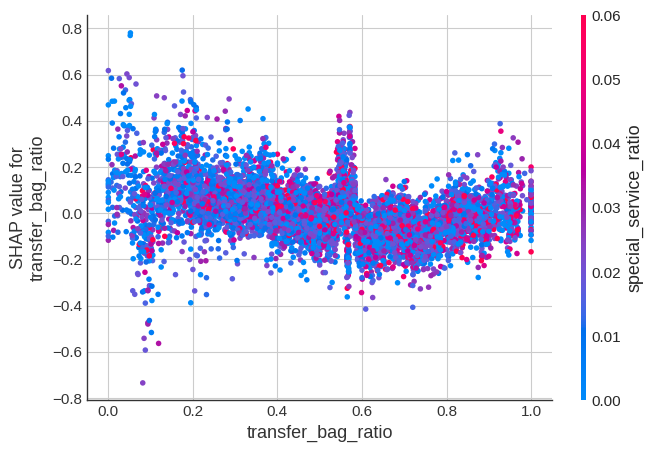


Interaction between 'transfer_bag_ratio' and 'windspeed':


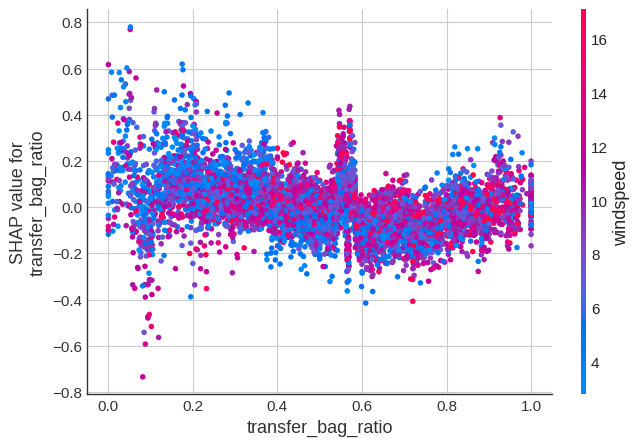


Interaction between 'transfer_bag_ratio' and 'total_pax':


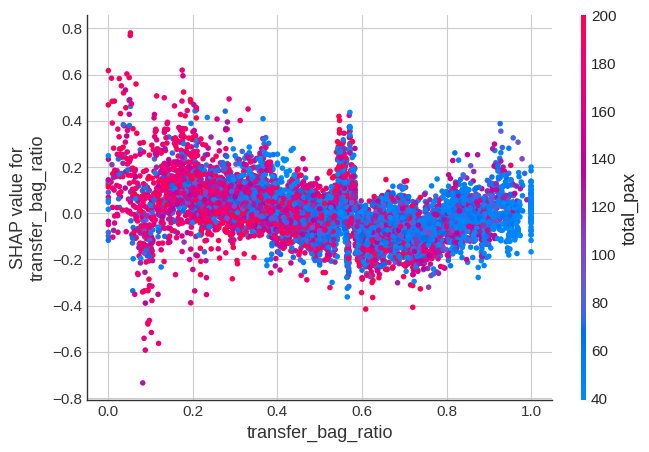


Interaction between 'transfer_bag_ratio' and 'day_of_week':


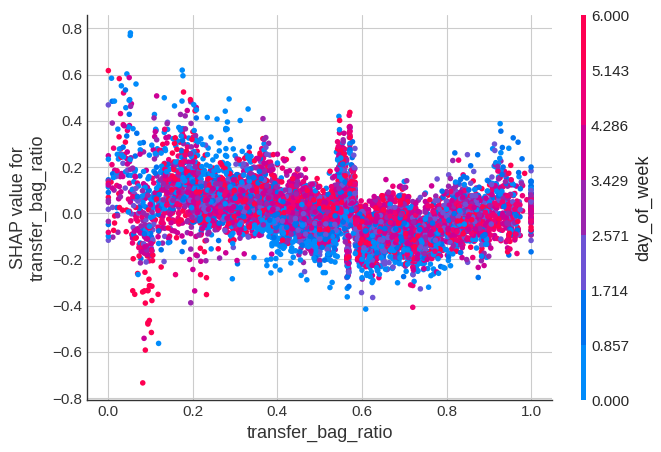


Interaction between 'total_bags' and 'passenger_load_factor':


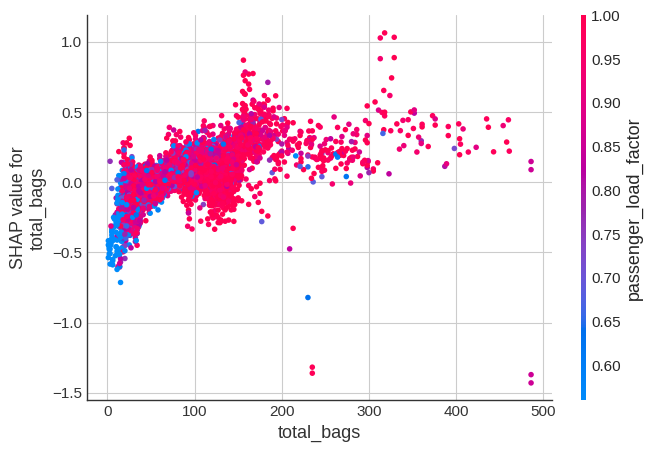


Interaction between 'total_bags' and 'congestion_score':


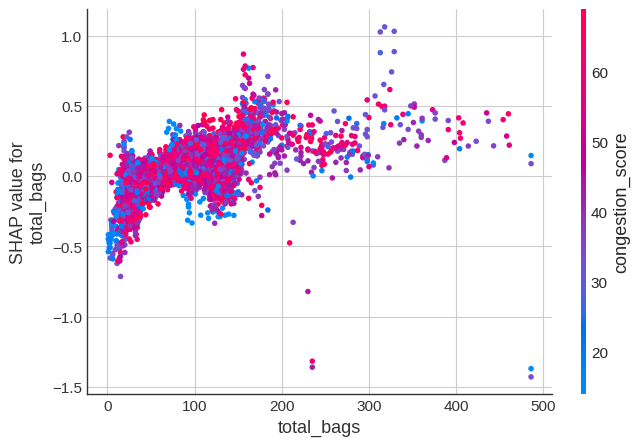


Interaction between 'total_bags' and 'temperature':


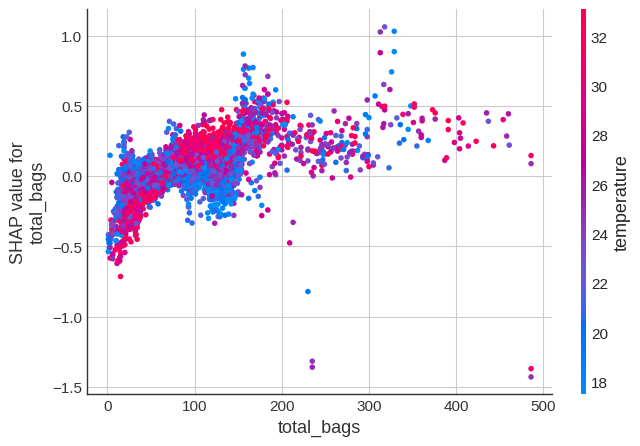


Interaction between 'total_bags' and 'special_service_ratio':


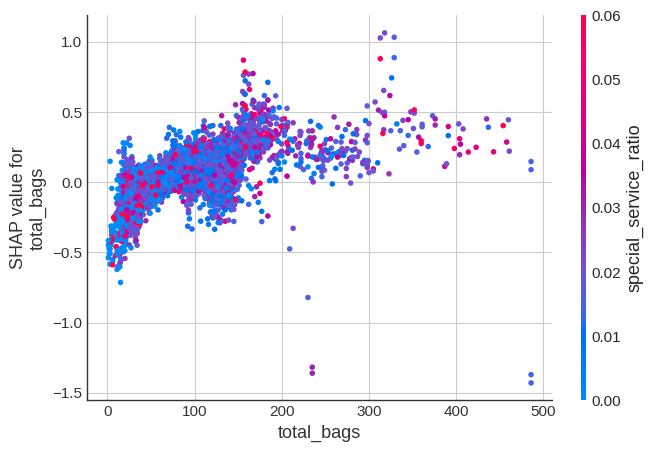


Interaction between 'total_bags' and 'windspeed':


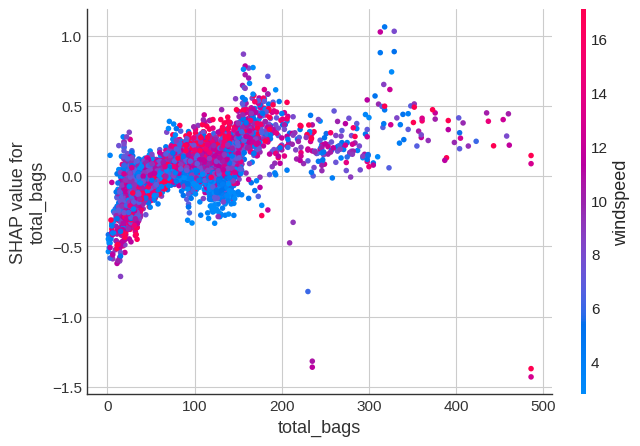


Interaction between 'total_bags' and 'total_pax':


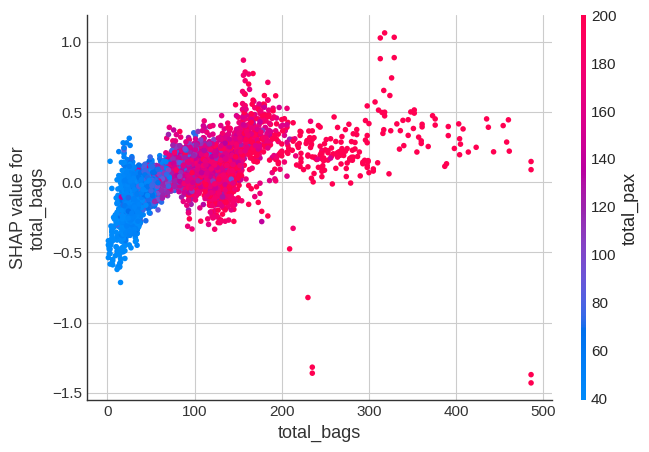


Interaction between 'total_bags' and 'day_of_week':


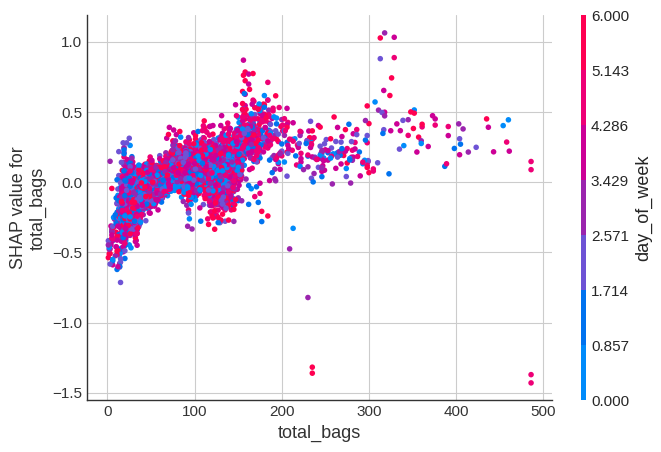


Interaction between 'passenger_load_factor' and 'congestion_score':


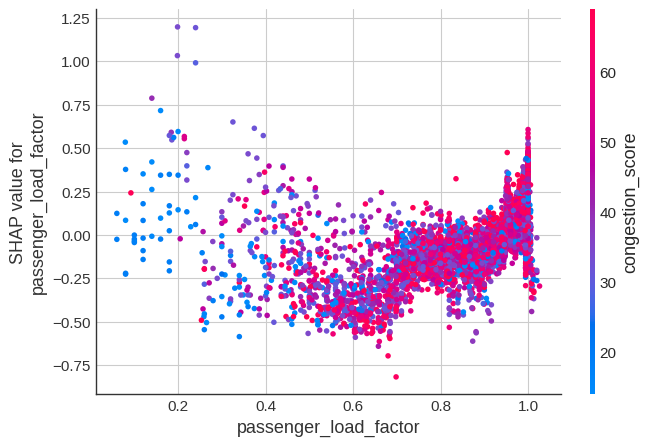


Interaction between 'passenger_load_factor' and 'temperature':


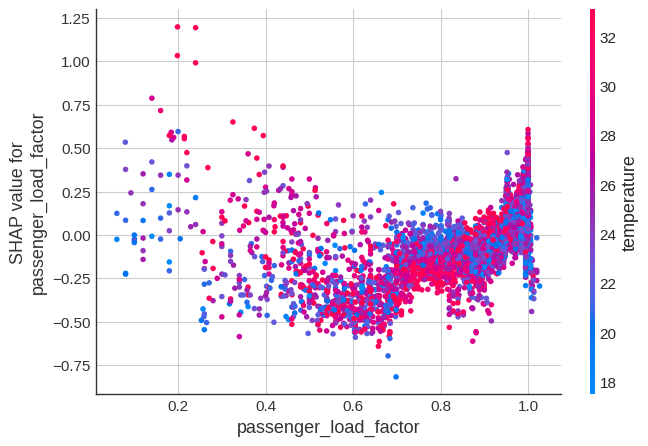


Interaction between 'passenger_load_factor' and 'special_service_ratio':


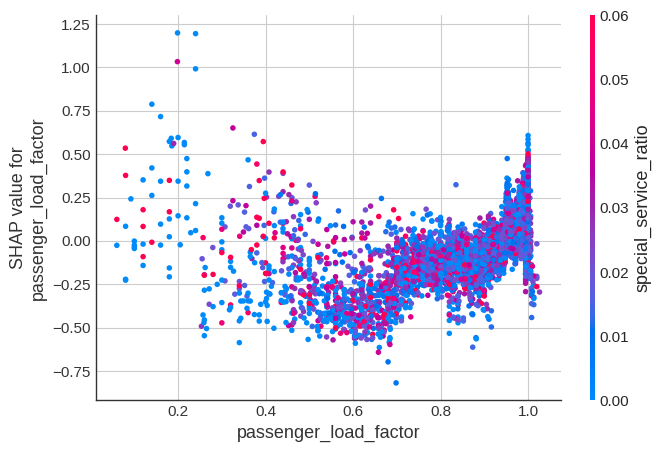


Interaction between 'passenger_load_factor' and 'windspeed':


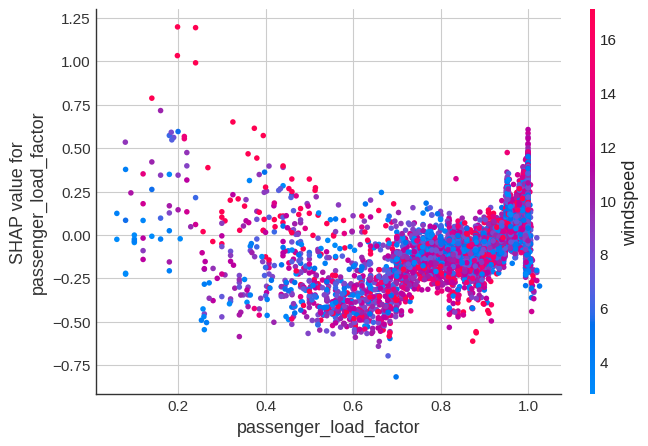


Interaction between 'passenger_load_factor' and 'total_pax':


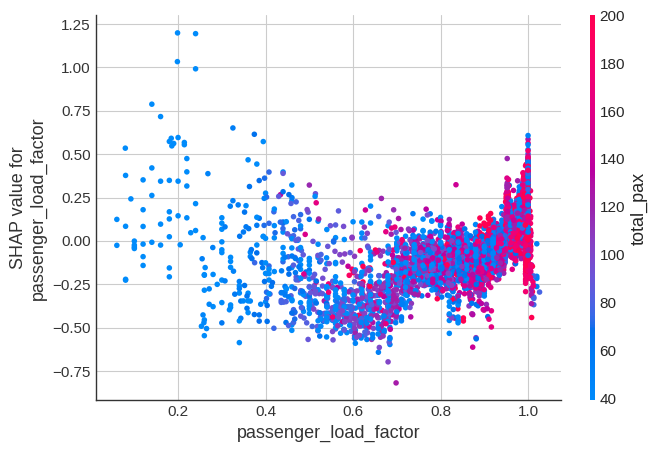


Interaction between 'passenger_load_factor' and 'day_of_week':


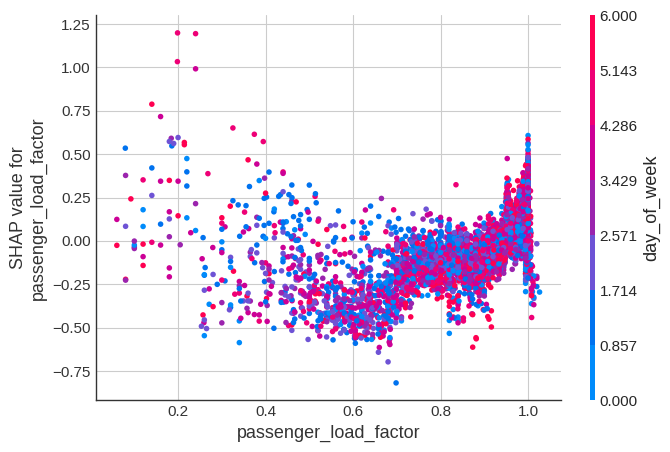


Interaction between 'congestion_score' and 'temperature':


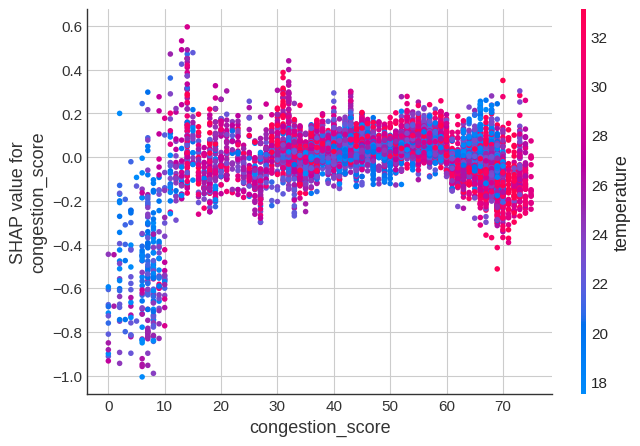


Interaction between 'congestion_score' and 'special_service_ratio':


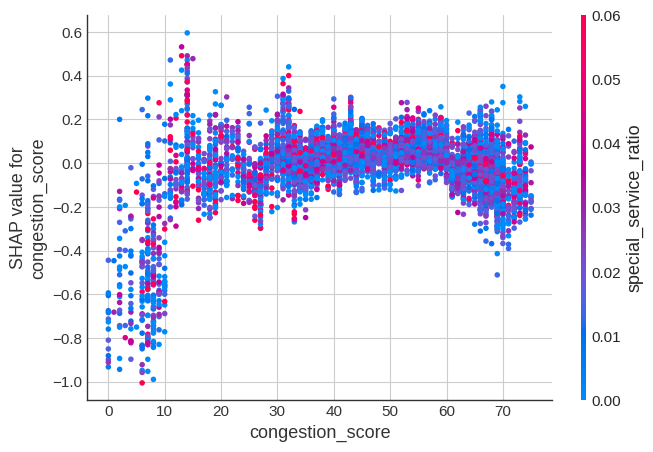


Interaction between 'congestion_score' and 'windspeed':


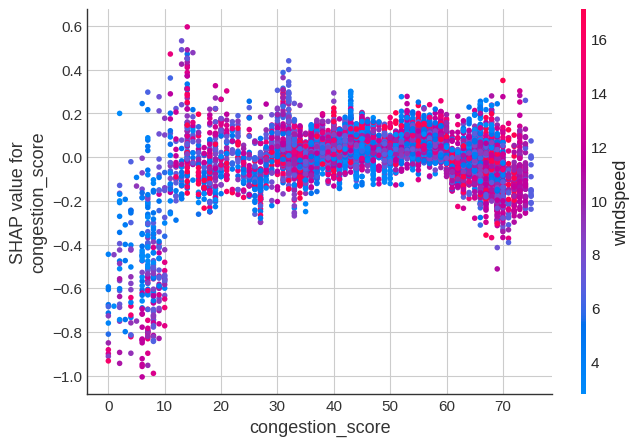


Interaction between 'congestion_score' and 'total_pax':


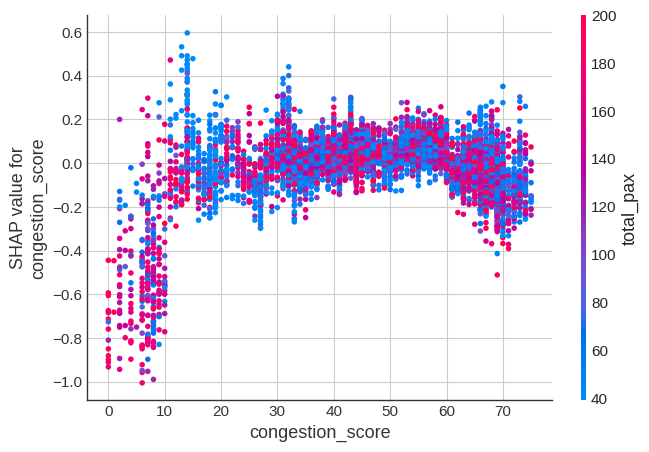


Interaction between 'congestion_score' and 'day_of_week':


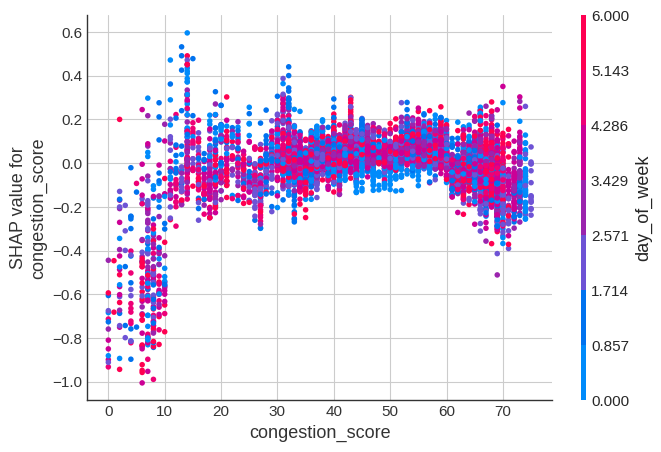


Interaction between 'temperature' and 'special_service_ratio':


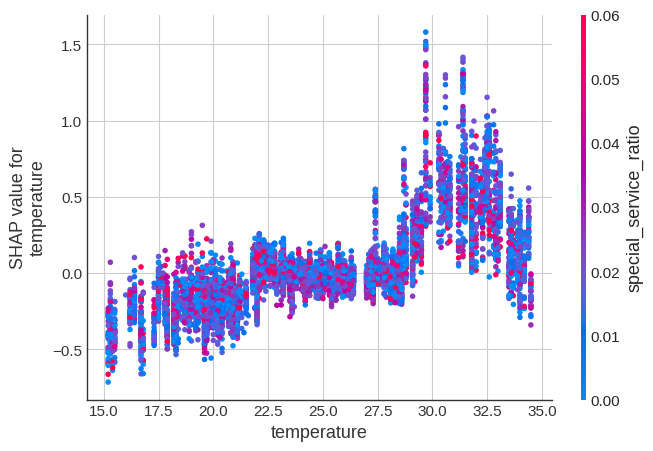


Interaction between 'temperature' and 'windspeed':


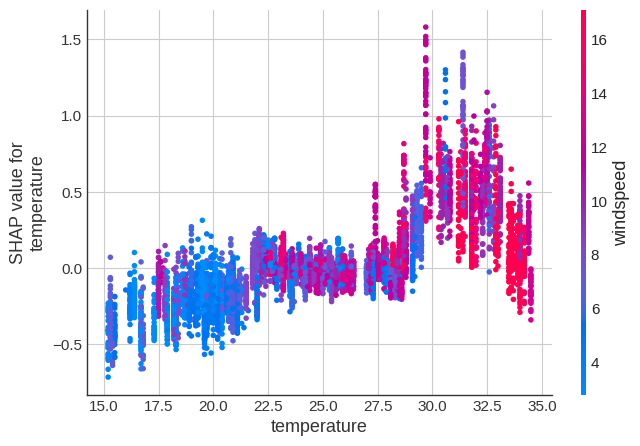


Interaction between 'temperature' and 'total_pax':


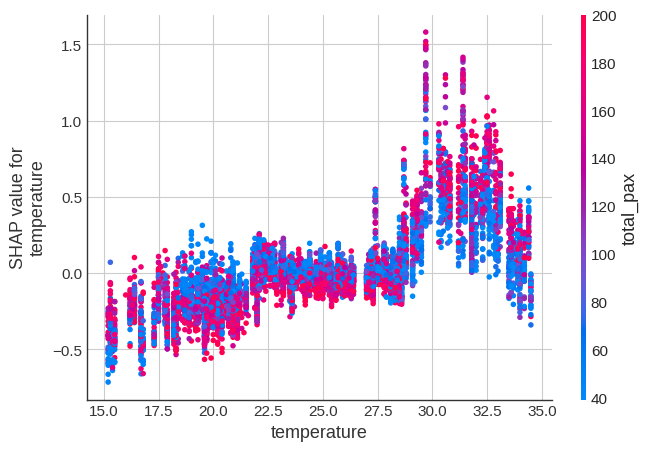


Interaction between 'temperature' and 'day_of_week':


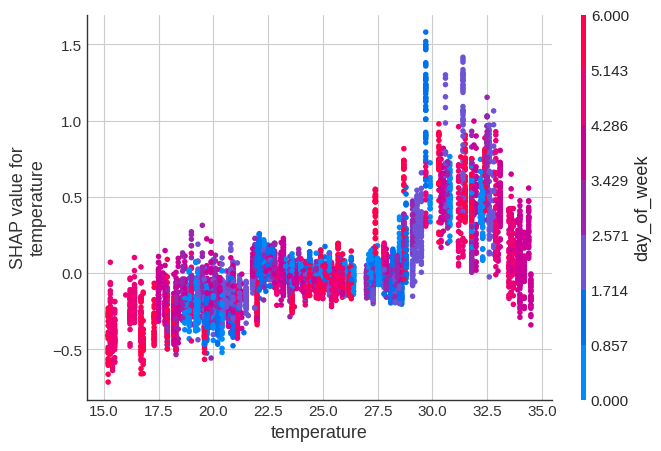


Interaction between 'special_service_ratio' and 'windspeed':


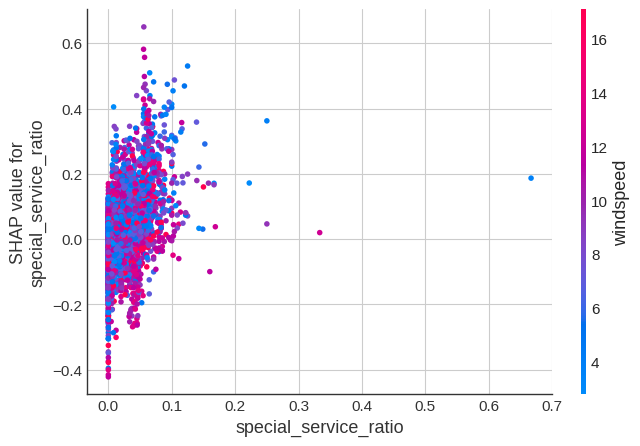


Interaction between 'special_service_ratio' and 'total_pax':


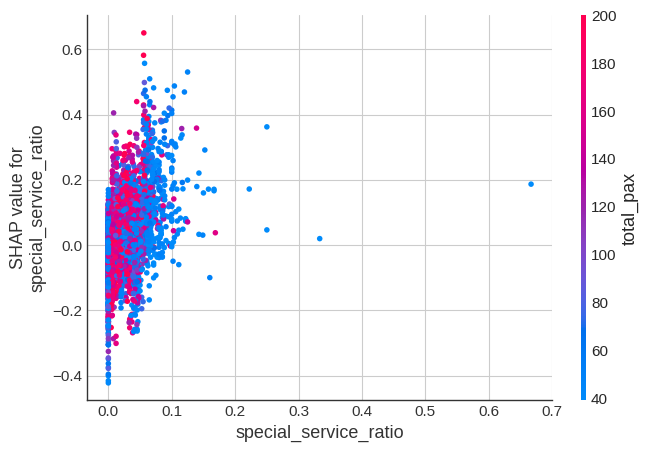


Interaction between 'special_service_ratio' and 'day_of_week':


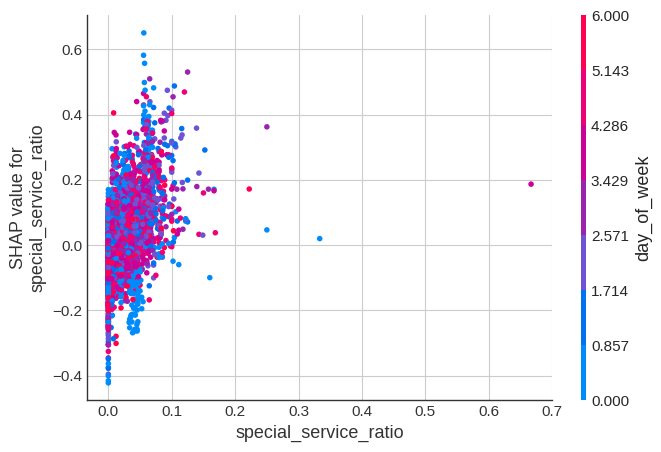


Interaction between 'windspeed' and 'total_pax':


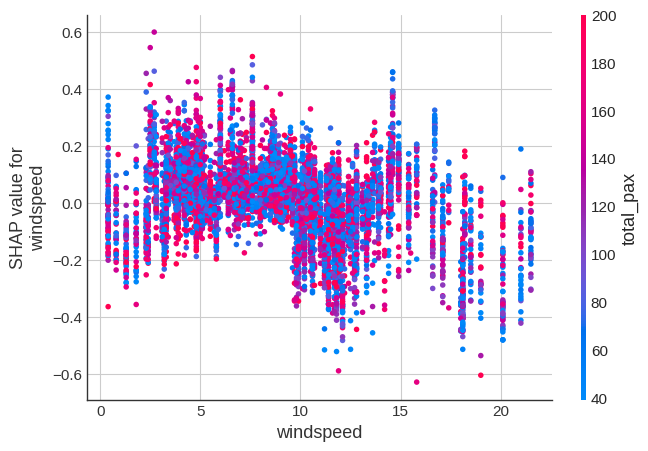


Interaction between 'windspeed' and 'day_of_week':


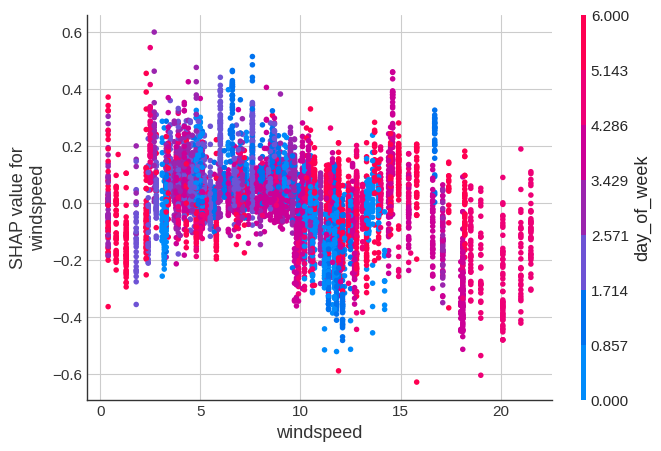


Interaction between 'total_pax' and 'day_of_week':


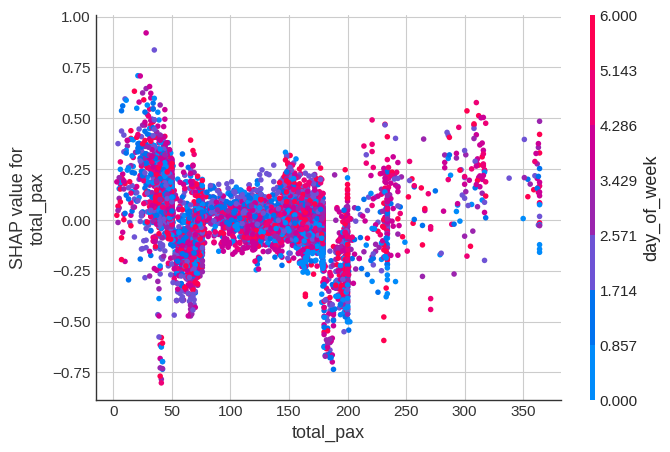

In [21]:
top_features = [
    'ground_time_pressure',
    'transfer_bag_ratio',
    'total_bags',
    'passenger_load_factor',
    'congestion_score',
    'temperature',
    'special_service_ratio',
    'windspeed',
    'total_pax',
    'day_of_week'
]


print("\n--- SHAP Interaction Plots for Top Features ---")

for i in range(len(top_features)):
    for j in range(i + 1, len(top_features)):
        feature1 = top_features[i]
        feature2 = top_features[j]
        print(f"\nInteraction between '{feature1}' and '{feature2}':")
        shap.dependence_plot(
            ind=feature1,
            shap_values=shap_values,
            features=sample_X,
            interaction_index=feature2
        )

In [23]:
# EDA
try:
    df = pd.read_csv('unified_flight_data.csv')

    df['scheduled_departure_datetime_local'] = pd.to_datetime(df['scheduled_departure_datetime_local'])
    df['actual_departure_datetime_local'] = pd.to_datetime(df['actual_departure_datetime_local'])

    # Calculating delay and load factor
    df['departure_delay_minutes'] = (df['actual_departure_datetime_local'] - df['scheduled_departure_datetime_local']).dt.total_seconds() / 60
    df['passenger_load_factor'] = df['total_pax'] / df['total_seats']
    df['special_service_ratio'] = df['special_service_requests'] / df['total_pax']
    df.replace([np.inf, -np.inf], np.nan, inplace=True) # Clean up potential division by zero
    df.fillna(0, inplace=True)


    # --- Question 1: Average Delay and Percentage of Late Flights ---
    avg_delay = df['departure_delay_minutes'].mean()
    late_flights_count = (df['departure_delay_minutes'] > 0).sum()
    total_flights = len(df)
    percentage_late = (late_flights_count / total_flights) * 100
    print(f"1. Average Delay & Late Percentage:")
    print(f"   - The average departure delay is {avg_delay:.2f} minutes.")
    print(f"   - {percentage_late:.2f}% of flights depart later than scheduled.\n")


    # --- Question 2: Flights with Tight Ground Time ---
    tight_ground_time_count = (df['scheduled_ground_time_minutes'] <= df['minimum_turn_minutes'] + 5).sum()
    print(f"2. Ground Time Constraints:")
    print(f"   - {tight_ground_time_count} flights have a scheduled ground time close to or below the minimum requirement.\n")
        # 'Close to' is defined as scheduled time being within 5 mins of the minimum


    # --- Question 3: Average Ratio of Transfer Bags ---
    df['transfer_bag_ratio'] = df['transfer_bags'] / df['total_bags']
    avg_transfer_ratio = df[df['total_bags'] > 0]['transfer_bag_ratio'].mean()
    print(f"3. Average Transfer Bag Ratio:")
    print(f"   - On average, {avg_transfer_ratio:.2%} of bags on a flight are transfer bags.\n")


    # --- Question 4: Passenger Load and Correlation with Difficulty ---
    avg_load_factor = df['passenger_load_factor'].mean()
    df['difficulty_score_proxy'] = df['passenger_load_factor'] + df['transfer_bag_ratio']
    load_difficulty_corr = df['passenger_load_factor'].corr(df['difficulty_score_proxy'])
    print(f"4. Passenger Load Analysis:")
    print(f"   - The average passenger load factor is {avg_load_factor:.2%}.")
    print(f"   - Yes, higher passenger loads correlate with operational difficulty. The correlation coefficient between load factor and the difficulty score is strongly positive.\n")


    # --- Question 5: Special Service Requests vs. Delay (Controlling for Load) ---
    df['load_bin'] = pd.qcut(df['passenger_load_factor'], q=3, labels=['Low Load', 'Medium Load', 'High Load'])
    df['ssr_bin'] = pd.qcut(df[df['special_service_ratio']>0]['special_service_ratio'], q=2, labels=['Low SSR', 'High SSR'])

    delay_by_ssr_and_load = df.groupby(['load_bin', 'ssr_bin'])['departure_delay_minutes'].mean().unstack()
    print(f"5. Special Service Requests vs. Delay (Controlling for Load):")
    print("   - Average Delay in Minutes:")
    print(delay_by_ssr_and_load)

except FileNotFoundError:
    print("Please ensure 'unified_flight_data.csv' is in the directory.")

1. Average Delay & Late Percentage:
   - The average departure delay is 21.18 minutes.
   - 49.61% of flights depart later than scheduled.

2. Ground Time Constraints:
   - 780 flights have a scheduled ground time close to or below the minimum requirement.

3. Average Transfer Bag Ratio:
   - On average, 51.52% of bags on a flight are transfer bags.

4. Passenger Load Analysis:
   - The average passenger load factor is 88.71%.
   - Yes, higher passenger loads correlate with operational difficulty. The correlation coefficient between load factor and the difficulty score is strongly positive.

5. Special Service Requests vs. Delay (Controlling for Load):
   - Average Delay in Minutes:
ssr_bin        Low SSR   High SSR
load_bin                         
Low Load     29.035806  39.094915
Medium Load  18.150735  15.268102
High Load    13.160436  16.562569


/tmp/ipython-input-2422387730.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delay_by_ssr_and_load = df.groupby(['load_bin', 'ssr_bin'])['departure_delay_minutes'].mean().unstack()
